### Prepare environment

In [1]:
!pip install --upgrade --quiet catboost kaggle

#### Imports

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

#### For google drive

Mount drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set up kaggle api

In [5]:
# Copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/ml2021/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#### Import files

In [3]:
# PATH = "/content/drive/MyDrive/Study/ML2021/home_credit/" # google drive
PATH = "../" # local

application_train = pd.read_csv(PATH + "data/raw/application_train.csv")
application_test = pd.read_csv(PATH + "data/raw/application_test.csv")

#### Utilities

In [4]:
def make_kaggle_submission(
    y_pred,
    submission_name : str
):
    sample_submission = pd.read_csv(PATH + 'data/raw/sample_submission.csv')
    sample_submission['TARGET'] = y_pred
    sample_submission.to_csv(PATH + 'data/submissions/' + submission_name, index = False)

    !kaggle competitions submit -c home-credit-default-risk -f {PATH}data/submissions/{submission_name} -m {submission_name}

## Catboost

### Intro

#### Turorials

CatBoost Tutorial \\
https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=XiUTmCvGvXF4

Solving classification problems with CatBoost \\
https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Gradient Boosting: CPU vs GPU \\
https://colab.research.google.com/github/catboost/tutorials/blob/master/tools/google_colaboratory_cpu_vs_gpu_tutorial.ipynb#scrollTo=C1jsWgxhCLTX


#### Simple catboost

In [5]:
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET

X_test = application_test.copy()

In [6]:
X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42)

cat_features_indices = np.where(X_train.dtypes != float)[0]

In [8]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
    random_seed=19,
    # task_type='GPU'
)

model.fit(
    X_train, y_train,
    cat_features=cat_features_indices,
    eval_set=(X_val, y_val),
    verbose=200,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6616844	test: 0.6616914	best: 0.6616914 (0)	total: 879ms	remaining: 2m 54s
199:	learn: 0.2491255	test: 0.2496903	best: 0.2496903 (199)	total: 2m 5s	remaining: 0us

bestTest = 0.2496902619
bestIteration = 199



![alt text](catboost_plots/simple_catboost.png)

In [12]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
make_kaggle_submission(y_pred_proba, "catboost_simple.csv")

100%|███████████████████████████████████████| 1.26M/1.26M [00:02<00:00, 592kB/s]
Successfully submitted to Home Credit Default Risk

**Result**

Private Score = 0.73976

Wow! Already better, than tuned Logistic Regression

### Tuning hyperparameters

#### Preparation

In [9]:
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET
X_test = application_test.copy()

X.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

categorical_features_indices = np.where(X.dtypes != float)[0]

In [10]:
default_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': 'AUC:hints=skip_train~false',
    'random_seed': 19,
    'cat_features': categorical_features_indices,
    'verbose': 0,
#     'task_type': 'GPU'
}

#### Simple model evaluation

Split data into train and validation folds, use built-in evaluator of CatBoostClassifier

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y)

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [16]:
learning_rates = [0.001, 0.03, 0.1, 0.2, 0.4, 0.8]
model_scores = dict()

In [21]:
for lr in learning_rates:
    # set learning rate
    params = default_params.copy()
    params['learning_rate'] = lr

    # train model
    model = CatBoostClassifier(**params)
    model.fit(
        train_pool, 
        eval_set=validate_pool,
        verbose=300,
    )

    # save validation score
    name = 'learning rate {}'.format(lr)
    score = model.best_score_['validation']['AUC']
    model_scores[name] = score

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5093643	test: 0.5078543	best: 0.5078543 (0)	total: 177ms	remaining: 17.5s
99:	learn: 0.7077887	test: 0.7033176	best: 0.7058516 (42)	total: 15.2s	remaining: 0us

bestTest = 0.7058516471
bestIteration = 42

Shrink model to first 43 iterations.
0:	learn: 0.5093643	test: 0.5078543	best: 0.5078543 (0)	total: 209ms	remaining: 20.7s
99:	learn: 0.7412928	test: 0.7349084	best: 0.7349084 (99)	total: 20.6s	remaining: 0us

bestTest = 0.7349084156
bestIteration = 99

0:	learn: 0.5093643	test: 0.5078543	best: 0.5078543 (0)	total: 179ms	remaining: 17.7s
99:	learn: 0.7581516	test: 0.7467376	best: 0.7467376 (99)	total: 18.6s	remaining: 0us

bestTest = 0.7467376341
bestIteration = 99

0:	learn: 0.5093643	test: 0.5078543	best: 0.5078543 (0)	total: 453ms	remaining: 44.9s
99:	learn: 0.7678922	test: 0.7496609	best: 0.7496794 (98)	total: 22.6s	remaining: 0us

bestTest = 0.7496794457
bestIteration = 98

Shrink model to first 99 iterations.
0:	learn: 0.5093643	test: 0.5078543	best: 0.5078543 (0)	to

In [22]:
model_scores

{'learning rate 0.001': 0.7058516471293153,
 'learning rate 0.03': 0.7349084156318242,
 'learning rate 0.1': 0.7467376340678413,
 'learning rate 0.2': 0.7496794457495396,
 'learning rate 0.4': 0.7504445590752166,
 'learning rate 0.8': 0.7426033049379984}

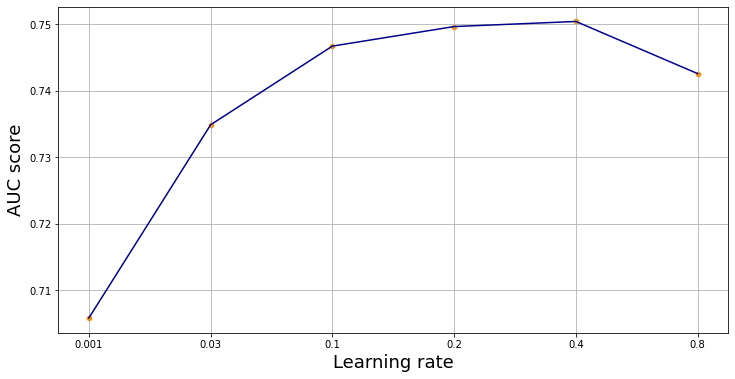

In [23]:
plt.figure(figsize=(12, 6))
plt.xlabel('Learning rate', size=18)
plt.ylabel('AUC score', size=18)

plt.grid()

rates = [score.split()[2] for score in model_scores.keys()]
scores = model_scores.values()

sns.scatterplot(rates, scores, color='darkorange')
sns.lineplot(rates, scores, color='darkblue')

plt.show()

**Result**

- From google colab with GPU with 500 iterations: learning rate 0.03 gives overfitting, 0.4 underfits it. Learning rate 0.1 seems to be the best.
    
- From local machine with 100 iterations: 0.4 is the best

**Next**

I've learned how to evaluate single model. 

Now let's implement a full grid search.

#### Grid search

In [11]:
grid = {
    'depth': [1, 2, 4],
    'learning_rate': [0.05, 0.1, 0.2], 
    'l2_leaf_reg': [3, 5, 10],
}

model = CatBoostClassifier(**default_params)

In [12]:
grid_search_result = model.grid_search(
    grid, 
    X=X,
    y=y,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7109347993
bestIteration = 99

0:	loss: 0.7109348	best: 0.7109348 (0)	total: 9.27s	remaining: 4m

bestTest = 0.7236935394
bestIteration = 99

1:	loss: 0.7236935	best: 0.7236935 (1)	total: 17.9s	remaining: 3m 43s

bestTest = 0.7337428325
bestIteration = 98

2:	loss: 0.7337428	best: 0.7337428 (2)	total: 26.2s	remaining: 3m 29s

bestTest = 0.7106677477
bestIteration = 98

3:	loss: 0.7106677	best: 0.7337428 (2)	total: 34.6s	remaining: 3m 18s

bestTest = 0.7231564889
bestIteration = 98

4:	loss: 0.7231565	best: 0.7337428 (2)	total: 42.7s	remaining: 3m 7s

bestTest = 0.7340609356
bestIteration = 99

5:	loss: 0.7340609	best: 0.7340609 (5)	total: 50.8s	remaining: 2m 57s

bestTest = 0.7107117699
bestIteration = 99

6:	loss: 0.7107118	best: 0.7340609 (5)	total: 59s	remaining: 2m 48s

bestTest = 0.7228140156
bestIteration = 99

7:	loss: 0.7228140	best: 0.7340609 (5)	total: 1m 7s	remaining: 2m 39s

bestTest = 0.7328249408
bestIteration = 98

8:	loss: 0.7328249	best: 0.7340609 (5)	tot

![alt text](catboost_plots/grid_search.png)

In [26]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.2}

#### Randomized search

I will use best parameters already defined by **grid_search** to help **randomized_search** to tune other parameters.

Difference of randomized search is that it tests only limited number of grid combinations == **n_iter** 

In [13]:
grid_rand = {
    'depth': [4],
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3], 
    'l2_leaf_reg': [3, 4, 10],
    'one_hot_max_size': [10, 20, 30]
}

model_rand = CatBoostClassifier(**default_params)

In [14]:
random_search_result = model_rand.randomized_search(
    grid_rand,
    X=X,
    y=y,
    n_iter=8,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.742249166
bestIteration = 99

0:	loss: 0.7422492	best: 0.7422492 (0)	total: 11.9s	remaining: 1m 23s

bestTest = 0.7469510484
bestIteration = 98

1:	loss: 0.7469510	best: 0.7469510 (1)	total: 23s	remaining: 1m 9s

bestTest = 0.7473181055
bestIteration = 98

2:	loss: 0.7473181	best: 0.7473181 (2)	total: 34s	remaining: 56.7s

bestTest = 0.7471219454
bestIteration = 99

3:	loss: 0.7471219	best: 0.7473181 (2)	total: 44.7s	remaining: 44.7s

bestTest = 0.7469073274
bestIteration = 99

4:	loss: 0.7469073	best: 0.7473181 (2)	total: 55.1s	remaining: 33.1s

bestTest = 0.7481075861
bestIteration = 99

5:	loss: 0.7481076	best: 0.7481076 (5)	total: 1m 6s	remaining: 22.1s

bestTest = 0.7423022666
bestIteration = 99

6:	loss: 0.7423023	best: 0.7481076 (5)	total: 1m 17s	remaining: 11s

bestTest = 0.741713141
bestIteration = 98

7:	loss: 0.7417131	best: 0.7481076 (5)	total: 1m 27s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.7525838124
bestIteration = 98


![alt text](catboost_plots/randomized_search.png)

In [30]:
random_search_result['params']

{'depth': 4, 'one_hot_max_size': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.3}

### Result evaluation

#### Tuned model

I will use the best params I received from grid search with google colab, computed on GPU.

In [31]:
best_params = {
    'iterations': 1000,
    'eval_metric': 'AUC:hints=skip_train~false',
    'cat_features': categorical_features_indices,
    'random_seed': 19,
    'depth': 4, 
    'l2_leaf_reg': 3, 
    'learning_rate': 0.2, 
    'one_hot_max_size': 10,
    'verbose': 200,
    'task_type': 'GPU'
}

In [32]:
tuned_model = CatBoostClassifier(**best_params)
tuned_model.fit(X, y)

0:	learn: 0.6226353	total: 76.7ms	remaining: 1m 16s
200:	learn: 0.7636449	total: 15.4s	remaining: 1m 1s
400:	learn: 0.7715742	total: 30.9s	remaining: 46.1s
600:	learn: 0.7778271	total: 46.3s	remaining: 30.7s
800:	learn: 0.7829541	total: 1m 1s	remaining: 15.4s
999:	learn: 0.7880896	total: 1m 17s	remaining: 0us


In [33]:
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]
make_kaggle_submission(y_pred_proba, "catboost_tuned.csv")

100% 1.26M/1.26M [00:01<00:00, 709kB/s]
Successfully submitted to Home Credit Default Risk

#### Kaggle Score

Private Score = 0.74558. Huge improvement again! Tuned parameters seem to be actually the best!

#### Most important features

YEARS_BUILD_MEDI: 22.445296851079174
YEARS_BEGINEXPLUATATION_MEDI: 15.775699012028614
BASEMENTAREA_MEDI: 5.842003830316
EXT_SOURCE_2: 5.076021306387628
CNT_FAM_MEMBERS: 4.665243370318206
EXT_SOURCE_1: 3.8791225999462116
APARTMENTS_MEDI: 2.5716607322982616
ENTRANCES_AVG: 2.282894955260016
YEARS_BEGINEXPLUATATION_MODE: 2.126630006640173
BASEMENTAREA_AVG: 1.8664488643006785
AMT_ANNUITY: 1.786139296703502
FLOORSMAX_AVG: 1.778672845765275
LANDAREA_AVG: 1.5780363136916657
REG_CITY_NOT_WORK_CITY: 1.5671216570543591


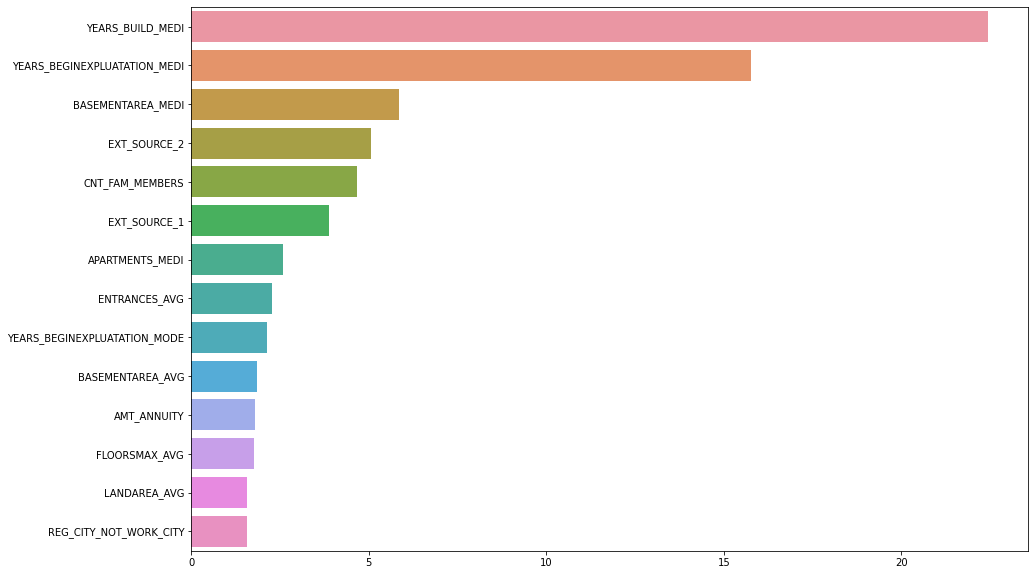

In [36]:
feature_importances = tuned_model.get_feature_importance()
feature_names = X_train.columns

scores = []
names = []

for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    if score < 1.5:
        break

    scores.append(score)
    names.append(name)
    print('{}: {}'.format(name, score))

plt.figure(figsize=(15, 10))
sns.barplot(y=names, x=scores, orient='h')
plt.show()  

Very strange features. This either proves unintuitiveness of underlying logic of whether a person will return credit or not, or shows model is overfitted. But kaggle score is the best yet, though  <<<>>>

## Stacking

### Data preparation

Not all models in our ensemble will be able to work with pure categorical data, therefore we need to prepare it.

In [37]:
def prepare_num_and_cat_data(X):

    # split data into numeric and categorical
    X_num = X.select_dtypes(include='float64')
    X_cat = X.select_dtypes(exclude='float64')

    num_cols = X_num.columns
    cat_cols = X_cat.columns

    # encode categorical data
    X_cat = X_cat.apply(LabelEncoder().fit_transform)

    # combine data
    X = pd.concat((X_num, X_cat), axis=1)

    # fill NaN with median value
    X = X.fillna(X.median())
    
    return X

In [38]:
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET

X_test = application_test.copy()

In [39]:
X = prepare_num_and_cat_data(X)
X_test = prepare_num_and_cat_data(X_test)
cat_indices = np.where(X.dtypes != float)[0]

In [40]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y)

### Model training

In [16]:
estimators = [
    ('lr', LogisticRegression(class_weight='balanced')),
    ('lr_scaled', make_pipeline(
        MinMaxScaler(),
        LogisticRegression(class_weight='balanced')
    )),
    ('catboost_no_cat_ft', CatBoostClassifier(
        iterations=200,
        verbose=300,
        task_type='GPU'
    )),
    ('catboost_with_cat_ft', CatBoostClassifier(
        iterations=200,
        cat_features=cat_indices,
        verbose=300,
        task_type='GPU'
    )),
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
]

In [ ]:
stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    verbose=1,
    cv=3
)
stacking_clf.fit(X_train, y_train)

In [23]:
roc_auc_score(y_validation, stacking_clf.predict_proba(X_validation)[:,1])

0.7524846556225062

In [26]:
y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]
make_kaggle_submission(y_pred_proba, "stacking_lr_catboost.csv")

100% 1.26M/1.26M [00:01<00:00, 1.24MB/s]
Successfully submitted to Home Credit Default Risk

**Result**

Private score = 0.73383.

Now let's try stacking without strongest model.

### Removing strongest model from stacking

In [46]:
weak_estimators = [
    ('lr', LogisticRegression(class_weight='balanced')),
    ('lr_scaled', make_pipeline(
        MinMaxScaler(),
        LogisticRegression(class_weight='balanced')
    )),
    ('catboost_with_cat_ft', CatBoostClassifier(
        iterations=200,
        cat_features=cat_indices,
        verbose=300,
        task_type='GPU'
    )),
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
]

In [ ]:
weak_stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    verbose=1,
    cv=3
)
weak_stacking_clf.fit(X_train, y_train)

In [48]:
roc_auc_score(y_validation, weak_stacking_clf.predict_proba(X_validation)[:,1])

0.755864844553909

In [49]:
y_pred_proba = weak_stacking_clf.predict_proba(X_test)[:, 1]
make_kaggle_submission(y_pred_proba, "weak_stacking_lr_catboost.csv")

100% 1.26M/1.26M [00:01<00:00, 689kB/s]
Successfully submitted to Home Credit Default Risk

**Result**

Private Score = 0.73788.

### Conclusion

Stacking is resistant to disabling single of it's models, but need to make all it's features numeric reduces usefullness of catboost classifier.

(?) Как сделать так, чтобы catboost не ухудшался после Label encoding-а ?

## Итоги

**Что я сделал**
- Обучил простую catboost-модель
- Научился валидировать ее
- Сделал grid search и random search
- Построил лучшую модель с найденными параметрами
- Определил самые важные фичи
- Построил StackingClassifier
- Выкинул из классификатора лучшую модель без ухудшения результата